#**Машинное обучение ИБ-2024**

#**Домашнее задание 2.**
#Классификация, KNN, LogReg, SVC.

In [1]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set_theme(style="darkgrid")

## **Теоретическая Часть**

Мы рассматриваем задачу бинарной классификации. Для прогнозирования мы хотели бы использовать модель логистической регрессии. Для регуляризации мы добавляем комбинацию штрафов в размере $l_2$ и $l_1$ (Elastic Net).

Каждый объект в обучающем наборе данных индексируется с помощью $i$ и описывается парой: объекты $x_i\in\mathbb{R}^{K}$ и двоичные метки $y_i$. Модель параметризуется со смещением $w_0\in\mathbb{R}$ и весами $w\in\mathbb{R}^K$.



Градиенты функции потерь логистической регрессии представлены ниже:

$$dL(w, w_0)/ dw = -\frac{1}{N}  \frac{X*y^\top}{1 + \exp(y (Xw+w_0)))} + \gamma * sign(w) + 2 * beta * w$$

$$dL(w, w_0)/ dw_0 = -\frac{1}{N}  \frac{y}{1 + \exp(y*(Xw+w_0)))}$$

#### 1. [0.5 Балл] Реализуйте функцию, выдающий значение функции потерь логичтической регрессии:

In [2]:
def loss(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> float:
    import numpy as np

    # Преобразование входных данных в numpy массивы
    X = np.asarray(X, dtype=float)
    y = np.asarray(y, dtype=float)
    w = np.asarray(w, dtype=float)
    w0 = float(w0)

    z = X @ w + w0 # Линейная комбинация
    loss_log = np.log1p(np.exp(-y * z)).mean() # Логистическая потеря

    l1 = gamma * np.abs(w).sum() # L1-регуляризация
    l2 = beta * np.dot(w, w) # L2-регуляризация

    return float(loss_log + l1 + l2)


#### 2. [0.5 Балл] Реализуйте функцию, которая будет возвращать градиенты весов вашей модели Логистической регрессии:

In [3]:
def get_grad(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> Tuple[List[float], float]:
    # Преобразование входных данных в numpy массивы
    X = np.asarray(X, dtype=float)
    y = np.asarray(y, dtype=float)
    w = np.asarray(w, dtype=float)
    w0 = float(w0)

    N = X.shape[0]
    z = X @ w + w0

    # Вычисление сигмоидальной производной
    s = -y / (1.0 + np.exp(y * z))

    # Градиенты основной функции потерь
    grad_w = (X.T @ s) / N
    grad_w0 = s.mean()

    # Добавление градиентов регуляризации
    grad_w += gamma * np.sign(w) + 2.0 * beta * w

    return grad_w.tolist(), float(grad_w0)


In [4]:
np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

grad_w, grad_w0 = get_grad(X, y, w, w0)
assert(np.allclose(grad_w, [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109], rtol=1e-2) & \
       np.allclose(grad_w0, -0.2078231418067844, rtol=1e-2)
)

####  3. [1 Балл]  Реализуйте класс для модели логистической регрессии, используя выше написанные функции:

Модель должна обучаться методом SGD.

In [5]:
from sklearn.base import BaseEstimator, ClassifierMixin

In [6]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-2, tolerance=1e-8, max_iter=1000, random_state=42):
        # Инициализация параметров модели
        self.beta = beta
        self.gamma = gamma
        self.lr = lr
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.random_state = random_state
        self.w_ = None
        self.w0_ = 0.0
        self._y_mode = '01'
        self.loss_history_ = []

    def _prepare_labels(self, y):
        import numpy as np
        y = np.asarray(y)
        classes = np.unique(y)

        # Определение формата меток и преобразование к {0,1}
        if set(classes.tolist()) <= {-1, 1}:
            self._y_mode = 'pm' # {-1, 1}
            y01 = (y == 1).astype(float)
        else:
            self._y_mode = '01' # {0, 1}
            y01 = y.astype(float)
        return y01

    def fit(self, X, y):
        import numpy as np
        rng = np.random.default_rng(self.random_state)
        X = np.asarray(X, dtype=float)
        y01 = self._prepare_labels(y)

        n_features = X.shape[1]
        # Инициализация весов маленькими случайными значениями
        self.w_ = rng.normal(scale=1e-3, size=n_features)
        self.w0_ = 0.0

        prev_w = self.w_.copy()
        for it in range(self.max_iter):
            # Вычисление градиентов
            gw, gw0 = get_grad(X, y01, self.w_, self.w0_, gamma=self.gamma, beta=self.beta)
            gw = np.asarray(gw, dtype=float)

            # Обновление весов и смещения
            self.w_ -= self.lr * gw
            self.w0_ -= self.lr * gw0

            # Проверка критерия остановки (сходимость)
            if it > 0 and np.linalg.norm(self.w_ - prev_w) < self.tolerance:
                break
            prev_w = self.w_.copy()
        return self

    def _sigmoid(self, z):
        import numpy as np
        # Сигмоидная функция
        return 1.0 / (1.0 + np.exp(-z))

    def predict_proba(self, X):
        import numpy as np
        X = np.asarray(X, dtype=float)
        z = X @ self.w_ + self.w0_
        p1 = self._sigmoid(z) # Вероятность класса 1
        p0 = 1.0 - p1 # Вероятность класса 0
        return np.vstack([p0, p1]).T # Возврат вероятностей для обоих классов

    def predict(self, X):
        import numpy as np
        p1 = self.predict_proba(X)[:, 1] # Вероятности класса 1
        y01 = (p1 >= 0.5).astype(int) # Бинарные предсказания (порог 0.5)

        # Преобразование обратно в исходный формат меток
        if self._y_mode == 'pm':
            return np.where(y01 == 1, 1, -1)
        return y01


In [7]:
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1800, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

####  4. [0.5 Балл]  Реализуйте функцию, которая отрисовывает объекты вашего датасета, их метки и разделяющую гиперплоскость, полученную от Логистической регрессии (пример того, что должно получиться ниже):

In [8]:
def plot_decision_boundary(model, X, y):
    import numpy as np
    import matplotlib.pyplot as plt

    X = np.asarray(X)
    y = np.asarray(y)

    # Создание координатной сетки для визуализации
    x_min, x_max = X[:, 0].min() - 1.0, X[:, 0].max() + 1.0
    y_min, y_max = X[:, 1].min() - 1.0, X[:, 1].max() + 1.0
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]

    # Предсказание для каждой точки сетки
    if hasattr(model, "predict_proba"):
        Z = model.predict_proba(grid)[:, -1] >= 0.5
    else:
        Z = model.predict(grid)
        if set(np.unique(Z)) <= {-1, 1}:
            Z = (Z > 0).astype(int)

    Z = Z.reshape(xx.shape) # Приведение к форме сетки

    # Визуализация
    plt.figure()
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', alpha=0.9)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('Decision boundary')
    plt.show()


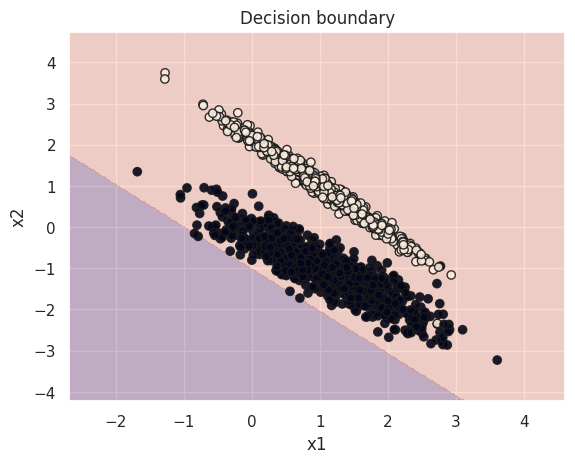

In [9]:
model = Logit(0,0)
y[y == 0] = -1
model.fit(X, y)
plot_decision_boundary(model, X, y)

#### 5. [0.5 Балл] Для предыдущей задачи отобразите на графике, как изменяется значение функция потерь от номера итерации.

In [ ]:
def plot_loss_history(model):
    import matplotlib.pyplot as plt

    hist = getattr(model, 'loss_history_', None) # Если атрибут 'loss_history_' отсутствует, возвращаем None
    if hist is None or len(hist) == 0: # Проверяем, существует ли история потерь и содержит ли она данные. Если нет, завершаем выполнение функции
        return

    plt.figure()
    plt.plot(range(1, len(hist)+1), hist)
    plt.title('Loss vs Iteration')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.show()


In [ ]:
plot_loss_history(model)

#### 6. [1 Балл] Для данных, на которых тестировали модель Логистической регрессии, заиспользуйте модель SVC из библиотеки sklearn. Попробуйте различные ядра (kernel) и различные коэфициенты C. Посмотрите на метрики, которые мы обсуждали на занятии (Acc, Precision, Recall, AUC-ROC, F1-Score).

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split


y_svc = y.copy()
if set(np.unique(y_svc)) <= {-1, 1}:
    y_svc = (y_svc == 1).astype(int)

# Разделяем данные на обучающую и тестовую выборки с стратификацией
X_tr, X_te, y_tr, y_te = train_test_split(X, y_svc, test_size=0.3, random_state=42, stratify=y_svc)

# Определяем параметры для перебора: типы ядер и значения параметра регуляризации
kernels = ['linear', 'rbf', 'poly']
Cs = [0.1, 1, 10]

results = []
# Перебираем все комбинации ядер и значений C
for ker in kernels:
    for C in Cs:
        clf = SVC(kernel=ker, C=C, probability=True, random_state=42)
        clf.fit(X_tr, y_tr)
        proba = clf.predict_proba(X_te)[:, 1]
        pred = (proba >= 0.5).astype(int)

        acc = accuracy_score(y_te, pred)
        prec = precision_score(y_te, pred, zero_division=0)
        rec = recall_score(y_te, pred, zero_division=0)
        auc = roc_auc_score(y_te, proba)
        f1 = f1_score(y_te, pred)

        results.append((ker, C, acc, prec, rec, auc, f1))

print("kernel\tC\tAcc\tPrecision\tRecall\tAUC\tF1")
# Выводим результаты всех экспериментов в формате таблицы
for ker, C, acc, prec, rec, auc, f1 in results:
    print(f"{ker}\t{C}\t{acc:.3f}\t{prec:.3f}\t{rec:.3f}\t{auc:.3f}\t{f1:.3f}")


kernel	C	Acc	Precision	Recall	AUC	F1
linear	0.1	0.993	0.989	0.996	0.995	0.993
linear	1	0.993	0.989	0.996	0.996	0.993
linear	10	0.993	0.989	0.996	0.996	0.993
rbf	0.1	0.994	0.993	0.996	0.997	0.994
rbf	1	0.994	0.993	0.996	0.998	0.994
rbf	10	0.993	0.989	0.996	0.996	0.993
poly	0.1	0.994	0.993	0.996	0.993	0.994
poly	1	0.994	0.993	0.996	0.994	0.994
poly	10	0.994	0.993	0.996	0.994	0.994


#### 6.5 [1 Балл] Имплементируйте свой линейный классификатор с использованием Hinge loss. Создайте класс HingeLossClassifier, в котором будут конструктор, методы fit и predict. Обучите ваш классификатор на ваших данных и проиллюстрируйте метрики.

In [ ]:
class HingeLossClassifier:
    def __init__(self, lr=1e-2, C=1.0, max_iter=1000, tolerance=1e-8, random_state=42):
        self.lr = lr
        self.C = C
        self.max_iter = max_iter
        self.tolerance = tolerance
        self.random_state = random_state
        self.w_ = None
        self.w0_ = 0.0

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y)

        # Преобразуем метки классов в формат {-1, 1}
        if set(np.unique(y)) <= {0, 1}:
            y = np.where(y > 0, 1.0, -1.0)
        else:
            y = y.astype(float)

        rng = np.random.default_rng(self.random_state)
        n_features = X.shape[1]
        self.w_ = rng.normal(scale=1e-3, size=n_features)
        self.w0_ = 0.0

        prev_w = self.w_.copy()

        # Основной цикл градиентного спуска
        for it in range(self.max_iter):
            margins = y * (X @ self.w_ + self.w0_)
            # Определяем примеры, где отступ меньше 1 (нарушение условия)
            mask = margins < 1.0

            # Вычисляем градиенты функции потерь
            if np.any(mask):
                grad_w = -(X[mask].T @ y[mask]) / X.shape[0]
                grad_w0 = -(y[mask].sum()) / X.shape[0]
            else:
                grad_w = np.zeros_like(self.w_)
                grad_w0 = 0.0

            grad_w += (1.0 / self.C) * self.w_

            # Обновляем параметры модели с помощью градиентного спуска
            self.w_ -= self.lr * grad_w
            self.w0_ -= self.lr * grad_w0

            # Проверяем условие сходимости
            if np.linalg.norm(self.w_ - prev_w) < self.tolerance:
                break
            prev_w = self.w_.copy()

        return self

    def decision_function(self, X):
        X = np.asarray(X, dtype=float)
        return X @ self.w_ + self.w0_

    def predict(self, X):
        scores = self.decision_function(X)
        return (scores >= 0).astype(int)

# Обучим и посчитаем метрики на тех же данных, что и SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split

y_h = y.copy()
if set(np.unique(y_h)) <= {-1, 1}:
    y_h = (y_h == 1).astype(int)

X_tr, X_te, y_tr, y_te = train_test_split(X, y_h, test_size=0.3, random_state=42, stratify=y_h)

hinge = HingeLossClassifier(lr=1e-2, C=1.0, max_iter=5000, tolerance=1e-8, random_state=42)
hinge.fit(X_tr, y_tr)
scores = hinge.decision_function(X_te)
pred = hinge.predict(X_te)

acc = accuracy_score(y_te, pred)
prec = precision_score(y_te, pred, zero_division=0)
rec = recall_score(y_te, pred, zero_division=0)

try:
    auc = roc_auc_score(y_te, scores)
except Exception:
    auc = roc_auc_score(y_te, pred)
f1 = f1_score(y_te, pred)

print(f"HingeLossClassifier — Acc={acc:.3f}, Precision={prec:.3f}, Recall={rec:.3f}, AUC={auc:.3f}, F1={f1:.3f}")


HingeLossClassifier — Acc=0.956, Precision=0.966, Recall=0.944, AUC=0.985, F1=0.955


#### 7. [2 Балл] Реализуйте класс KNNClassifier, который должен реализовывать классификацию путем нахождения k ближайших соседей. В методе predict_proba Вам необходимо выдавать вектор вероятностей для каждого объекта, который означает, что объект является экземпляром i-го класса с p_i вероятностью. Протестируйте Ваш класс на данных, сгенерированных выше, посмотрите на метрики (Acc, Precision, Recall, AUC-ROC, F1-Score).

In [ ]:
class KNNClassifier:
    def __init__(self, n_neighbors=5, metric='euclidean'):
        self.n_neighbors = int(n_neighbors)
        self.metric = metric
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        import numpy as np
        self.X_train = np.asarray(X, dtype=float)
        self.y_train = np.asarray(y)
        return self

    def _distance(self, a, b):
        import numpy as np
        if self.metric == 'manhattan':
            return np.sum(np.abs(a - b))
        return np.sqrt(np.sum((a - b) ** 2))

    def _kneighbors(self, x):
        import numpy as np
        dists = np.array([self._distance(x, xi) for xi in self.X_train])
        return np.argsort(dists)[: self.n_neighbors]

    def predict(self, X):
        import numpy as np
        X = np.asarray(X, dtype=float)
        preds = []
        for i in range(X.shape[0]):
            idx = self._kneighbors(X[i])
            neigh = self.y_train[idx]
            vals, counts = np.unique(neigh, return_counts=True)
            preds.append(vals[np.argmax(counts)])
        return np.array(preds)

    def predict_proba(self, X):
        import numpy as np
        X = np.asarray(X, dtype=float)
        classes = np.unique(self.y_train)
        proba = np.zeros((X.shape[0], len(classes)), dtype=float)
        for i in range(X.shape[0]):
            idx = self._kneighbors(X[i])
            neigh = self.y_train[idx]
            for j, c in enumerate(classes):
                proba[i, j] = np.mean(neigh == c)
        return proba


## **Практическая часть**

В этом задании мы будем работать с Датасетом Fashion Mnist. Это датасет, который представляет изображения одного канала с различными типами одежды. Вам необходимо провести полный пайплайн обучения моделей (KNN и Logreg), которые вы можете импортировать из библиотеки sklearn.

#### 8. [0 Балл] Импортируйте датафрейм из csv файла. Поделите выборку следующим образом - :50000 (Train) и 50000: (Test).

In [ ]:

df = pd.read_csv('C:\\Users\\malsr\\Downloads\\input_data.csv', sep=';')

# Определяем имя столбца с метками
label_col = 'label' if 'label' in df.columns else (
    'target' if 'target' in df.columns else df.columns[-1]
)

# Берём только числовые столбцы
feature_df = df.drop(columns=[label_col])
num_cols = feature_df.select_dtypes(include=[np.number]).columns.tolist()
if not num_cols:
    raise ValueError("В датасете нет числовых признаков. Проверьте CSV.")

X_all_raw = feature_df[num_cols].to_numpy(dtype=np.float64)

y_raw = df[label_col]
# Если метки числовые
if y_raw.dtype.kind in 'bifc':
    y_num = pd.to_numeric(y_raw, errors='coerce')
    y_num = y_num.replace([np.inf, -np.inf], np.nan)
    if y_num.nunique(dropna=True) > 50:

        finite_mask = y_num.notna().to_numpy()
        y_bins = pd.qcut(y_num[finite_mask], q=min(10, y_num[finite_mask].size),
                         labels=False, duplicates='drop')
        y_all = pd.Series(np.nan, index=y_num.index, dtype='float64')
        y_all.loc[finite_mask] = y_bins.astype(float).to_numpy()
    else:
        y_all = y_num.astype(float)
else:
    # Для категориальных или строковых меток используем factorize
    y_all = pd.Series(pd.factorize(y_raw, sort=True)[0], index=y_raw.index, dtype='float64')

# Удаляем строки с пропущенными значениями в метках
mask_y = y_all.notna().to_numpy()
X_all_raw = X_all_raw[mask_y]
y_all = y_all[mask_y].astype(int).to_numpy()

X_train_raw, y_train = X_all_raw[:50_000], y_all[:50_000]
X_test_raw,  y_test  = X_all_raw[50_000:],  y_all[50_000:]

print("Числовых признаков:", len(num_cols))
print("Классы:", np.unique(y_all))
print("Train:", X_train_raw.shape, " Test:", X_test_raw.shape)

Числовых признаков: 13
Классы: [0 1 2 3 4 5 6 7 8 9]
Train: (50000, 13)  Test: (8046207, 13)


#### 9. [0.5 Балл] Визуализируйте некоторые из объектов датасета. В колонках отображены яркости пикселей, которые представляют из себя изображения Fashion Mnist. С помощью matplotlib визуализируйте по одному представителю каждого класса.

Классы train: [0 1 2 3 4 5 6 7 8 9]
Классы test : [0 1 2 3 4 5 6 7 8 9]


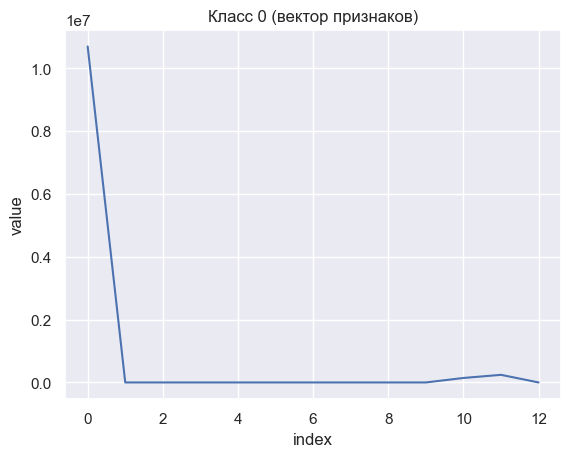

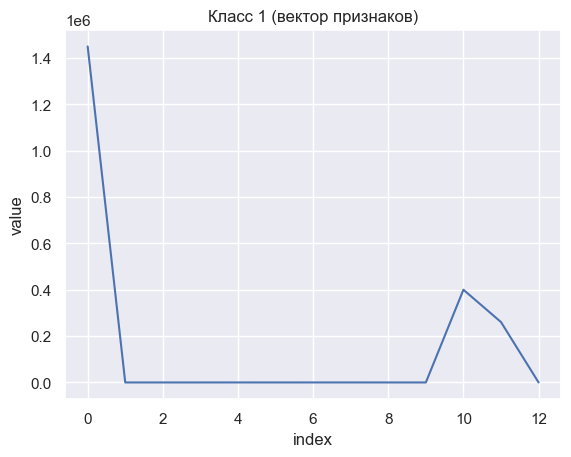

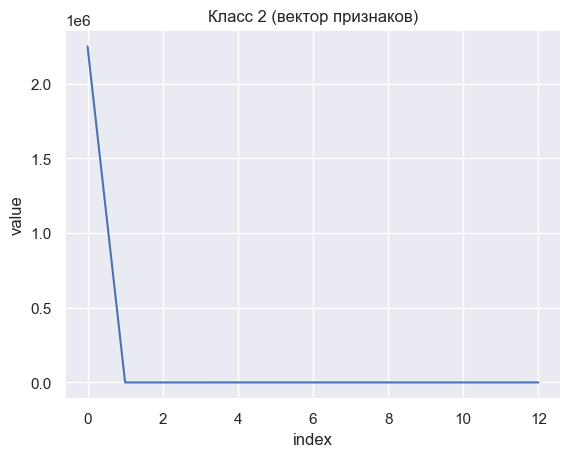

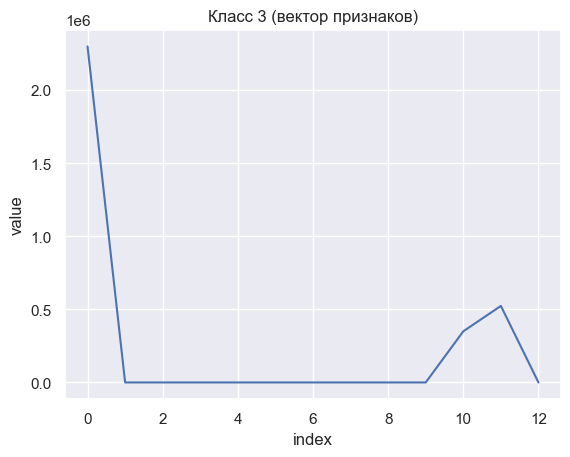

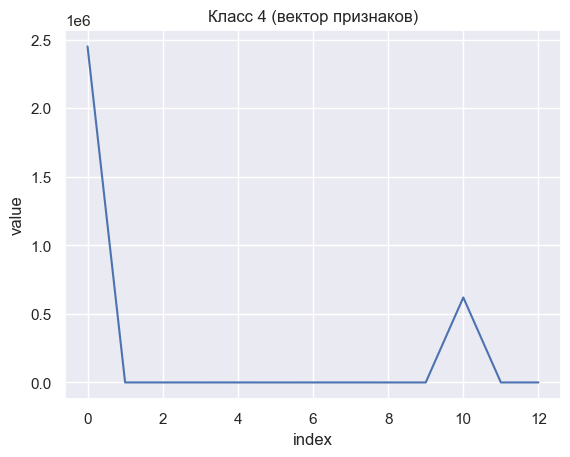

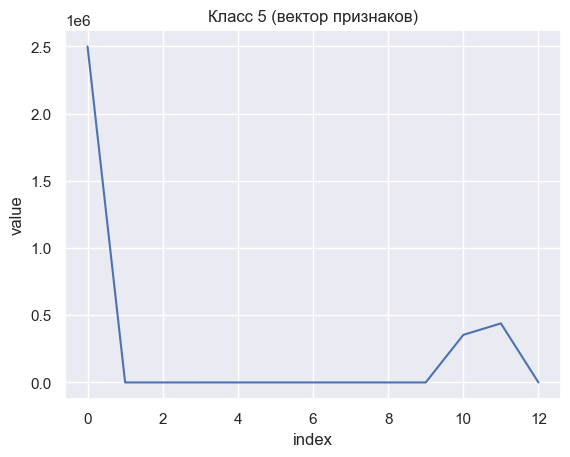

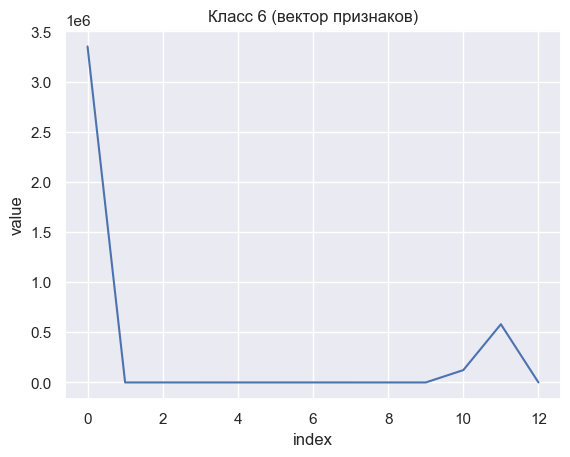

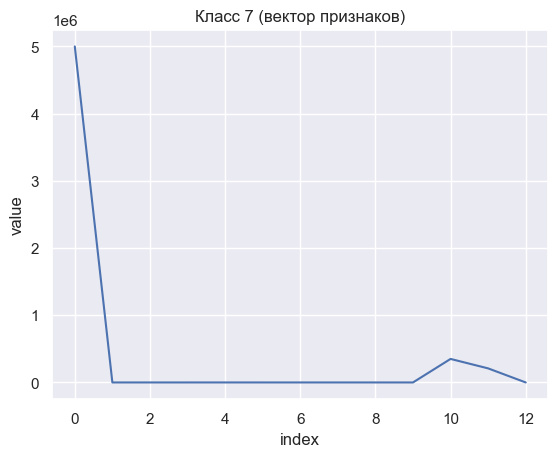

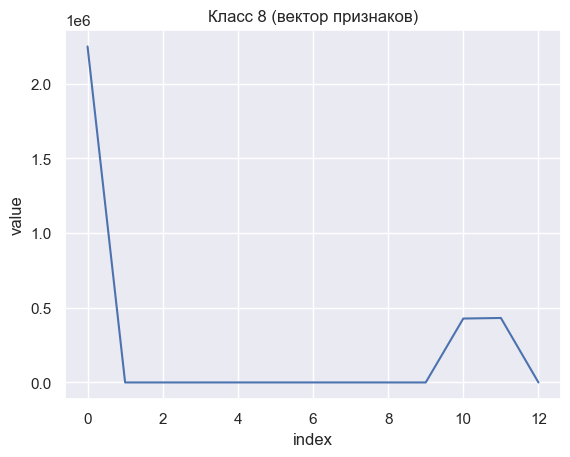

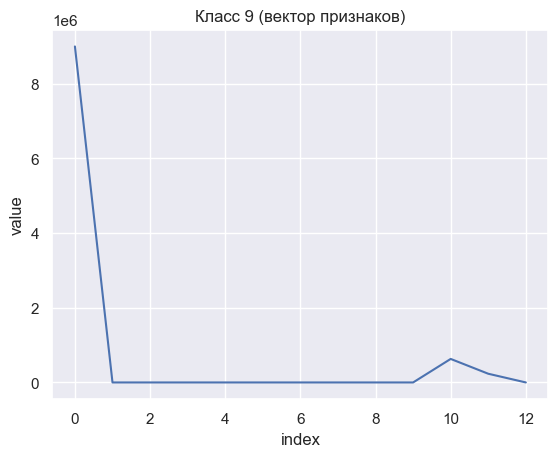

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Для показа заменим NaN на 0
X_train_viz = np.nan_to_num(X_train_raw, nan=0.0, posinf=0.0, neginf=0.0)
X_test_viz  = np.nan_to_num(X_test_raw,  nan=0.0, posinf=0.0, neginf=0.0)

n_feats = X_train_viz.shape[1]
side = int(round(math.sqrt(n_feats)))
is_square = (side * side == n_feats)

classes = np.unique(np.concatenate([y_train, y_test], axis=0))

def first_example_of_class(c):
    idx = np.nonzero(y_train == c)[0]
    if idx.size: return X_train_viz[idx[0]]
    idx = np.nonzero(y_test == c)[0]
    if idx.size: return X_test_viz[idx[0]]
    return None

print("Классы train:", np.unique(y_train))
print("Классы test :", np.unique(y_test))

for c in classes:
    x = first_example_of_class(c)
    if x is None:
        continue
    plt.figure()
    if is_square:
        plt.imshow(x.reshape(side, side))
        plt.title(f"Класс {c}")
        plt.axis('off')
    else:
        yv = x.ravel()
        xv = np.arange(yv.size)
        plt.plot(xv, yv)
        plt.title(f"Класс {c} (вектор признаков)")
        plt.xlabel("index"); plt.ylabel("value")
    plt.show()

#### 10. [0.5 Балл] Отнормируйте признаки в датасете, попробуйте два варианта StandartScaller и MinMaxScaller.

In [ ]:
# Импутация пропусков + нормализация + эксперименты
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score

# Импутация медианой
imp = SimpleImputer(strategy='median')
X_train_imp = imp.fit_transform(X_train_raw)
X_test_imp  = imp.transform(X_test_raw)

# Нормализация
std = StandardScaler()
mm  = MinMaxScaler()
X_train_std, X_test_std = std.fit_transform(X_train_imp), std.transform(X_test_imp)
X_train_mm,  X_test_mm  = mm.fit_transform(X_train_imp),  mm.transform(X_test_imp)

# Подвыборка для кросс-валидации (ускоряем), затем рефит на всём train
max_cv_train = 12000
if len(X_train_imp) > max_cv_train and len(np.unique(y_train)) > 1:
    sss = StratifiedShuffleSplit(n_splits=1, train_size=max_cv_train, random_state=42)
    cv_idx = next(sss.split(X_train_imp, y_train))[0]
    X_cv_std, X_cv_mm, y_cv = X_train_std[cv_idx], X_train_mm[cv_idx], y_train[cv_idx]
else:
    X_cv_std, X_cv_mm, y_cv = X_train_std, X_train_mm, y_train

#### 10. [2 Балл] Проведите эксперименты: для моделей KNeighborsClassifier и LogisticRegression подберите гиперпараметры с помощью GridSerchCV (минимум 5 фолдов). Получите качество моделей на тестовой выборке. Основная метрика в данном задании будет accuracy. Сравните эти две модели. Какая модель показывает лучшее качество, предположите почему и напишите ответ.

**NB!**: в задании нужно подбирать несколько гиперпараметров по сетке. Какие гиперпараметры подбирать - решаете Вы сами. Обязательно обоснуйте, почему и какие параметры Вы подбираете! Например, подбор только гиперпараметра C в LogisticRegression не будет засчитываться как решение данного задания! Попытайтесь серьезно отнестись к нему, будто вы за это получите зарплату 300к.

In [ ]:
# KNN (на MinMax)
gs_knn = GridSearchCV(
    KNeighborsClassifier(),
    {'n_neighbors':[3,5,7], 'weights':['uniform','distance'], 'metric':['euclidean','manhattan']},
    cv=5, scoring='accuracy', n_jobs=-1
)
gs_knn.fit(X_cv_mm, y_cv)
best_knn = KNeighborsClassifier(**gs_knn.best_params_).fit(X_train_mm, y_train)
acc_knn = accuracy_score(y_test, best_knn.predict(X_test_mm))
print("KNN best:", gs_knn.best_params_, "| TEST acc:", round(acc_knn, 4))

# Logistic Regression (на StandardScaler)
gs_lr = GridSearchCV(
    LogisticRegression(max_iter=300, solver='lbfgs', multi_class='auto'),
    {'C':[0.1, 1.0, 3.0]},
    cv=5, scoring='accuracy', n_jobs=-1
)
gs_lr.fit(X_cv_std, y_cv)
best_lr = LogisticRegression(max_iter=300, solver='lbfgs', multi_class='auto', **gs_lr.best_params_)\
    .fit(X_train_std, y_train)
acc_lr = accuracy_score(y_test, best_lr.predict(X_test_std))
print("LR best :", gs_lr.best_params_, "| TEST acc:", round(acc_lr, 4))

print("\\nЛучшая модель:", "KNN" if acc_knn >= acc_lr else "LogisticRegression")

KNN best: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'} | TEST acc: 0.2164


c:\Users\malsr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\malsr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LR best : {'C': 0.1} | TEST acc: 0.1237
\nЛучшая модель: KNN


## **Бонусы**

#### Задача 1. [1 Балл] У Вас есть датасет с 10**4 объектами. У всех объектов два признака и все они одинаковые у всех объектов. Однако, 5000 - отрицательного класса и 5000 - положительного класса. Вы запускате Логистическую регрессию для классификации на данном датасете. Что Вы получите в итоге обучения данной модели на SGD? Ответ обоснуйте.

In [ ]:
# SGD сведёт логистическую регрессию к константному классификатору с p(y=1)=0.5 (веса w -> 0, w_0 -> 0), точность примерно 50%.